In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from musicautobot.imports import *
from musicautobot.numpy_encode import *
from musicautobot.vocab import *
from musicautobot.music_transformer.transform import *
from musicautobot.music_transformer.dataloader import *

In [3]:
from fastai.text.all import *


## MusicTransformer Training

MusicTransformer takes the basic idea of [Language Models](https://en.wikipedia.org/wiki/Language_model) and applies it to Music.  

Given a sequence of notes, predict the next most likely set of notes.

This model is based off of [transformer-XL](https://arxiv.org/abs/1901.02860) and uses fast.ai's [implementation](https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py) of it.

In [4]:
# base_path = Path('../../data')

# # Location of your midi files
# midi_path = base_path/'midi/examples'
# midi_path.mkdir(parents=True, exist_ok=True)

# # Location to save dataset
# data_path = base_path/'numpy'
# data_path.mkdir(parents=True, exist_ok=True)

# data_save_name = 'musicitem_data_save.pkl'

In [5]:
base_path = Path('../../data/v20')
midi_path = base_path/'midi_sources/hooktheory'

data_path = base_path/'piano_duet/hooktheory'


## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [9]:
vocab = MusicVocab.create()
np_files = get_files(data_path, '.npy', recurse=True); len(np_files)

39933

In [10]:
class MusicItemTfm(Transform):
    "`PreProcessor` that transforms numpy files to indexes for training"
    def __init__(self,vocab):
        self.vocab = vocab
        
    def encodes(self, f):
        npitem = np.load(f, allow_pickle=True) if isinstance(f, Path) else f
        miitem = MusicItem.from_npenc(npitem, vocab=self.vocab)
        return miitem

In [70]:
subset = np_files[:400]
# tfms = [MusicItemTfm(vocab), rand_transpose, mi2tensor]
tfms = [MusicItemTfm(vocab), rand_transpose, lambda x: x.data]
splits = RandomSplitter(seed=42)(range(len(subset)))
dsets = Datasets(subset, [tfms], splits=splits)

## We rely on lru_cache to make sure random_transform doesn't get called twice on the same sequence.
Theoretically, setting cache to batch size should never result in a cache miss. Every sequence should be called once per batch. However, let's quadruple it just to be safe

In [71]:
bs = 10
dls = dsets.dataloaders(dl_type=LMDataLoader, bs=bs, seq_len=128, cache=bs*4).cuda()

In [72]:
# dls = DataLoaders.from_dsets(dsets, dl_type=LMDataLoader, bs=bs, seq_len=128, cache=bs*4).cuda() # does not work. validation set not created

## 3. Load Model

In [73]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [74]:
import transformers

In [75]:
from transformers import TransfoXLLMHeadModel, TransfoXLConfig

In [76]:

def default_config():
    config = tfmerXL_lm_config.copy()
    config['act'] = Activation.GeLU

    config['mem_len'] = 512
    config['d_model'] = 512
    config['d_inner'] = 2048
    config['n_layers'] = 16

    config['n_heads'] = 8
    config['d_head'] = 64

    return config


In [77]:
config = TransfoXLConfig(
    vocab_size=len(vocab), cutoffs=[],
    d_model=512, d_embed=512,
    n_head=8, d_head=64, 
    d_inner=2048, n_layer=16, 
    mem_len=512)

In [78]:
model = TransfoXLLMHeadModel(config).cuda()

In [79]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[Perplexity(), accuracy])#.to_fp16()

In [80]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,2.905030,2.611338,13.617257,0.363434,01:51
1,2.666336,2.531543,12.572888,0.364029,01:51


## 4. Train

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,3.398574,3.373378,0.174725,00:22
1,3.173110,3.283443,0.148352,00:20
2,3.235486,3.205513,0.174725,00:20
3,3.154775,3.102941,0.252747,00:20


In [11]:
learn.save('example')

PosixPath('../../data/numpy/models/example.pth')

## 5. Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [13]:
midi_file = base_path/'midi/notebook_examples/single_bar_example.mid'; midi_file
item = MusicItem.from_file(midi_file, data.vocab);

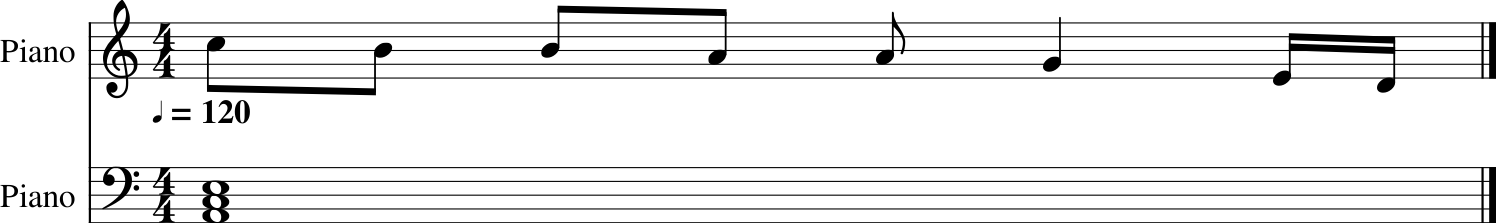

In [14]:
item.show()

Here's what the seed sounds like:

### Start Predictions:

In [ ]:
pred, full = learn.predict(item, n_words=100)

Prediction

In [ ]:
# Prediction
pred.show()

In [ ]:
pred.play()